<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [14]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [15]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 16

dls16 = parks_block.dataloaders(dataset_path, bs=16)

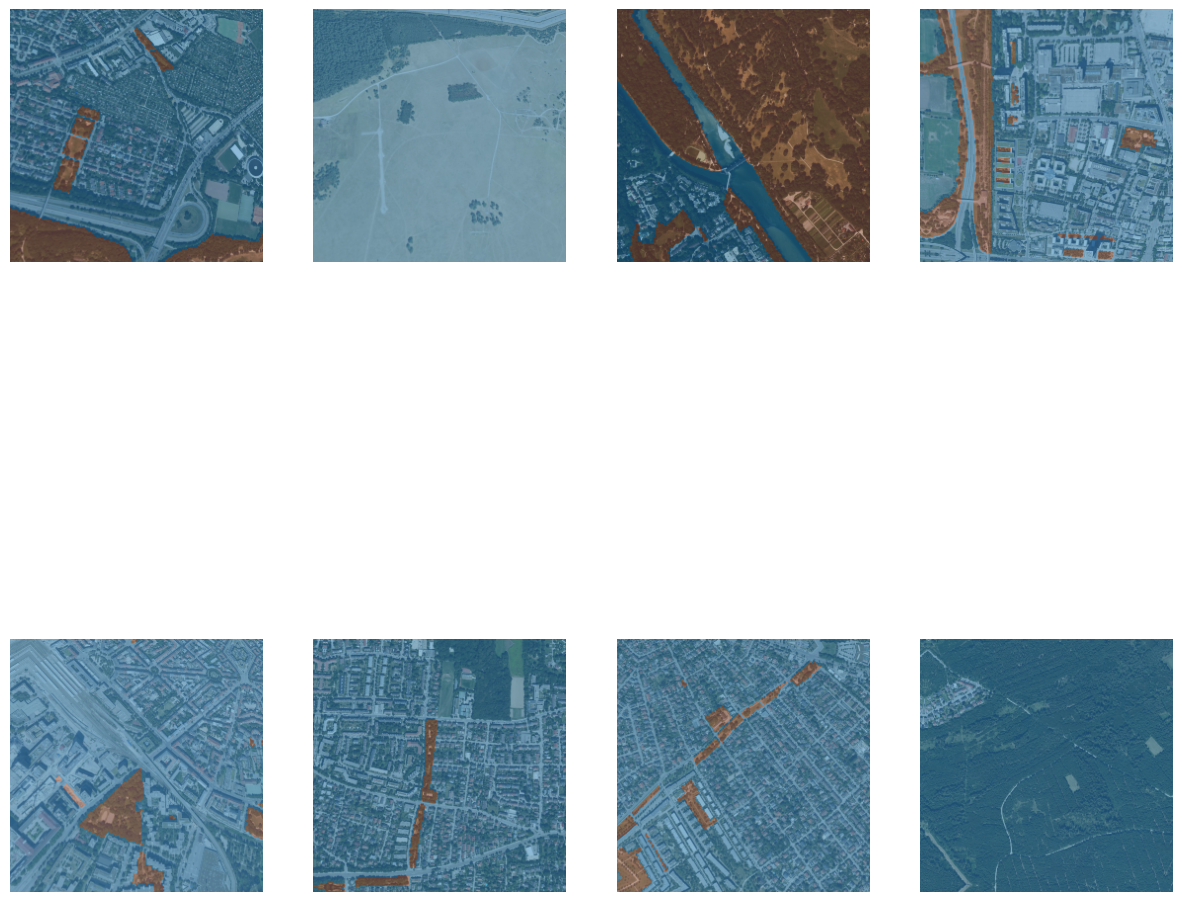

In [16]:
dls16.show_batch(max_n=8, figsize=(15, 15))

SuggestedLRs(valley=0.00010964782268274575)

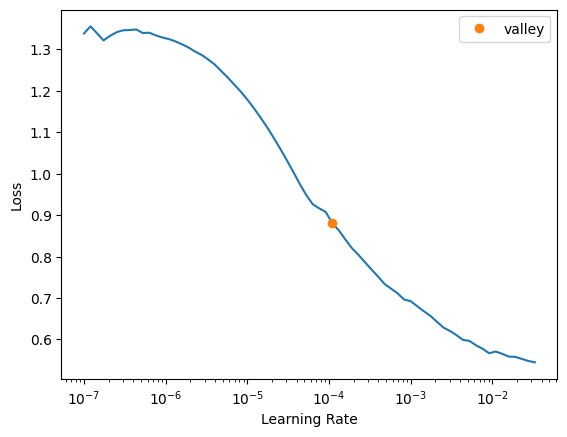

In [17]:
learn = unet_learner(dls16,resnet34,metrics=Dice)
learn.lr_find()

In [18]:
learn.fit_one_cycle(20, lr_max=7.585775892948732e-05, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_fr')])

epoch,train_loss,valid_loss,dice,time
0,0.936741,0.548963,0.058334,00:21
1,0.608338,0.315403,0.000433,00:23
2,0.460333,0.262715,0.000106,00:23
3,0.383710,0.245843,0.000106,00:21
4,0.339575,0.238869,0.000078,00:22
5,0.304129,0.207530,0.000095,00:21
6,0.278754,0.198694,0.008522,00:23
7,0.252437,0.188570,0.150937,00:21
8,0.233768,0.184809,0.408172,00:22
9,0.228093,0.231624,0.424464,00:21


Better model found at epoch 0 with dice value: 0.05833432412125283.
Better model found at epoch 7 with dice value: 0.15093650479947765.
Better model found at epoch 8 with dice value: 0.4081720976722299.
Better model found at epoch 9 with dice value: 0.42446446893392276.
Better model found at epoch 11 with dice value: 0.4663636464524598.
